# Imports

In [1]:
import sys
sys.path.append('..')

from src.utils import identify_missing_quarters, preprocess_text, extract_ngrams, sentiment_polarity
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import nltk
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
import plotly.express as px

# Get the Data

In [2]:
#constants
YEARS = range(datetime.now().year - 5, datetime.now().year + 1)  # Last 5 years

In [3]:
data_directory = '../data/raw/'
transcript_files = glob.glob(os.path.join(data_directory, '*_transcripts.json'))

all_transcripts = []

for file in transcript_files:
    transcript_df = pd.read_json(file)
    all_transcripts.append(transcript_df)

# Combine all DataFrames into a single DataFrame
combined_transcripts_df = pd.concat(all_transcripts, ignore_index=True)

combined_transcripts_df.head()

,symbol,quarter,year,date,content
0,AAL,3,2023,2023-10-19 12:37:10,Operator: Thank you for standing by and welcom...
1,AAL,2,2023,2023-07-20 11:51:04,"Operator: Thank you for standing by, and welco..."
2,AAL,1,2023,2023-04-27 11:15:04,"Operator: Thank you for standing by, and welco..."
3,AAL,4,2022,2023-01-26 12:53:07,"Operator: Thank you for standing by, and welco..."
4,AAL,3,2022,2022-10-20 14:26:04,"Operator: Thank you for standing by, and welco..."


# Inspect

Starting with high level statistics

In [4]:
len(combined_transcripts_df['symbol'].unique())

15

In [5]:
combined_transcripts_df['symbol'].value_counts()

symbol
AAL      23
ALGT     23
ALK      23
DAL      23
HA       23
JBLU     23
LUV      23
SKYW     23
UAL      23
ATSG     22
MESA     20
SAVE     20
SNCY     11
ULCC     10
JETMF     7
Name: count, dtype: int64

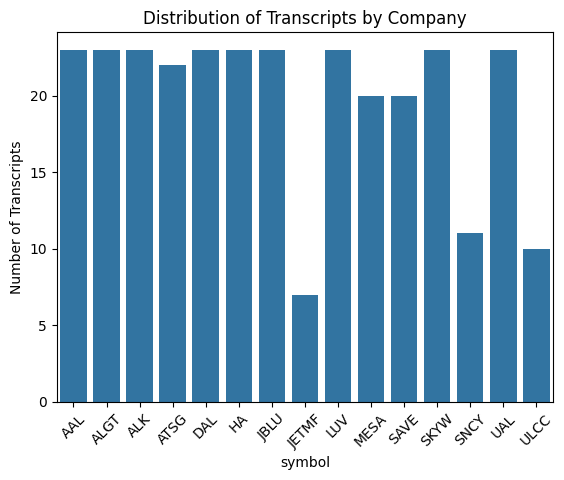

In [6]:
# Distribution by company
transcript_counts = combined_transcripts_df.groupby('symbol').size()
sns.barplot(x=transcript_counts.index, y=transcript_counts.values)
plt.xticks(rotation=45)
plt.title('Distribution of Transcripts by Company')
plt.ylabel('Number of Transcripts')
plt.show()

## Check Missing Transcripts

Company quarters do not always line up with the calendar year. Let's start with evaluating what quarters are missing and not include the current quarter.

In [7]:
missing_quarters_by_company = identify_missing_quarters(combined_transcripts_df)

# Print out missing quarters
for symbol, missing_quarters in missing_quarters_by_company.items():
    if missing_quarters:
        print(f"{symbol} is missing transcripts for the following quarters/years: {missing_quarters}")

ATSG is missing transcripts for the following quarters/years: [(3, 2020)]
JETMF is missing transcripts for the following quarters/years: [(1, 2018), (2, 2018), (3, 2018), (4, 2018), (1, 2019), (2, 2019), (3, 2019), (4, 2019), (1, 2020), (2, 2020), (3, 2020), (4, 2020), (1, 2021), (2, 2021), (2, 2022), (3, 2023)]
MESA is missing transcripts for the following quarters/years: [(1, 2018), (2, 2018), (3, 2018)]
SAVE is missing transcripts for the following quarters/years: [(4, 2019), (4, 2021), (3, 2023)]
SNCY is missing transcripts for the following quarters/years: [(1, 2018), (2, 2018), (3, 2018), (4, 2018), (1, 2019), (2, 2019), (3, 2019), (4, 2019), (1, 2020), (2, 2020), (3, 2020), (4, 2020)]
ULCC is missing transcripts for the following quarters/years: [(1, 2018), (2, 2018), (3, 2018), (4, 2018), (1, 2019), (2, 2019), (3, 2019), (4, 2019), (1, 2020), (2, 2020), (3, 2020), (4, 2020), (4, 2021)]


Visualizing the missing quarters to make it easier to see. 

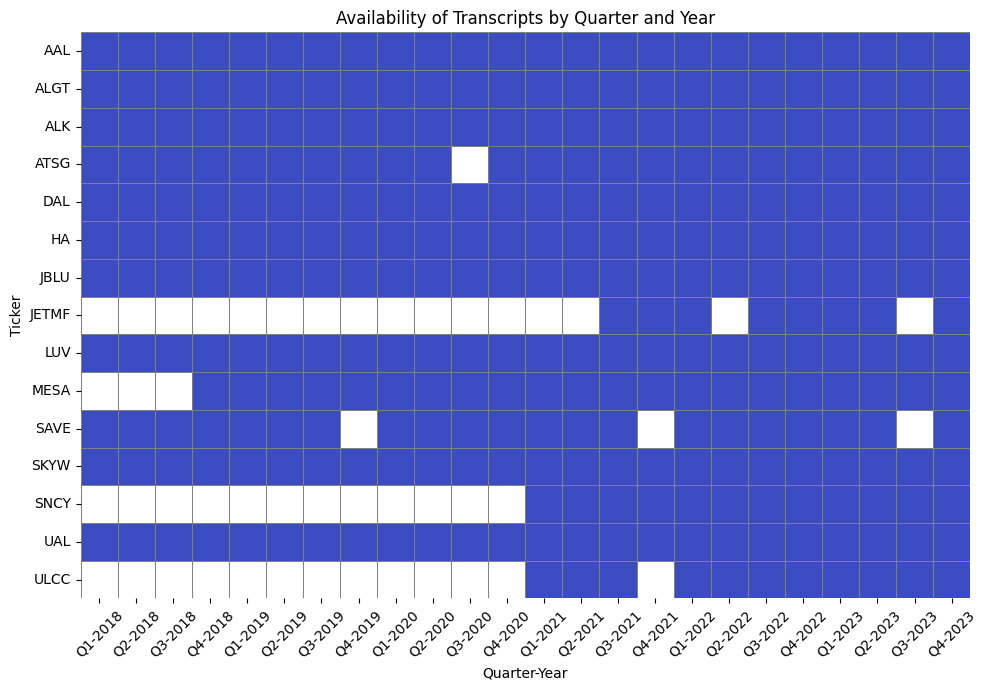

In [8]:
# Create a DataFrame to represent the presence or absence of transcripts
expected_quarters = [(q, y) for y in YEARS for q in range(1, 5)]
heatmap_data = pd.DataFrame(index=pd.MultiIndex.from_tuples(expected_quarters, names=["Quarter", "Year"]),
                            columns=combined_transcripts_df['symbol'].unique())
heatmap_data = heatmap_data.astype(float)

# Fill the DataFrame: 1 for available, NaN for missing
for symbol in combined_transcripts_df['symbol'].unique():
    for quarter, year in expected_quarters:
        heatmap_data.at[(quarter, year), symbol] = 1 if (quarter, year) not in missing_quarters_by_company[symbol] else np.nan

quarter_year_labels = [f"Q{q}-{y}" for y in YEARS for q in range(1, 5)]

# Plot the heatmap
plt.figure(figsize=(10, 7))

# Define custom color map
cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(heatmap_data.T, cmap=cmap, cbar=False, 
            linewidths=.5, linecolor='grey', # adding grey cell outlines
            xticklabels=quarter_year_labels, yticklabels=True)

# Rotate labels for improved visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

# Title and labels
plt.title('Availability of Transcripts by Quarter and Year')
plt.xlabel('Quarter-Year')
plt.ylabel('Ticker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Process and Inspect Transcript Contents

Applying basic processing here. Based on initial analysis and results, further processing will be needed

In [9]:
# Apply preprocessing to each transcript
# Removing stopwords, applying lemmatization 
combined_transcripts_df['clean_content'] = combined_transcripts_df['content'].apply(preprocess_text)
combined_transcripts_df

,symbol,quarter,year,date,content,clean_content
0,AAL,3,2023,2023-10-19 12:37:10,Operator: Thank you for standing by and welcom...,operator thank standing welcome american airli...
1,AAL,2,2023,2023-07-20 11:51:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
2,AAL,1,2023,2023-04-27 11:15:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
3,AAL,4,2022,2023-01-26 12:53:07,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
4,AAL,3,2022,2022-10-20 14:26:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
...,...,...,...,...,...,...
292,ULCC,2,2022,2022-07-28 23:29:08,"Operator: Ladies and gentlemen, thank you for ...",operator lady gentleman thank standing welcome...
293,ULCC,1,2022,2022-04-29 17:39:29,"Operator: Good day, and thank you for standing...",operator good day thank standing welcome front...
294,ULCC,3,2021,2021-11-10 22:51:03,"Operator: Ladies and gentlemen, thank you for ...",operator lady gentleman thank standing welcome...
295,ULCC,2,2021,2021-08-06 19:06:08,"Operator: Hello, and welcome to the Frontier G...",operator hello welcome frontier group holding ...


In [10]:
# Word count before cleaning
combined_transcripts_df['word_count'] = combined_transcripts_df['content'].apply(lambda text: len(text.split()))

# Word count after cleaning
combined_transcripts_df['clean_word_count'] = combined_transcripts_df['clean_content'].apply(lambda text: len(text.split()))

# Display statistics
print(combined_transcripts_df[['word_count', 'clean_word_count']].describe())


         word_count  clean_word_count
count    297.000000        297.000000
mean    9563.235690       4993.636364
std     2518.864013       1287.905272
min     3930.000000       2148.000000
25%     7950.000000       4132.000000
50%     9654.000000       5078.000000
75%    11014.000000       5853.000000
max    17205.000000       8211.000000


Word Counts

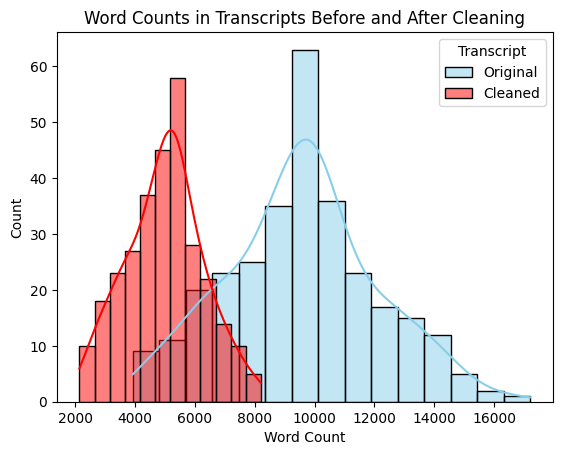

In [11]:
# Calculate word counts for each transcript
combined_transcripts_df['word_count'] = combined_transcripts_df['content'].apply(lambda text: len(text.split()))
combined_transcripts_df['clean_word_count'] = combined_transcripts_df['clean_content'].apply(lambda text: len(text.split()))

# Plotting word counts before and after cleaning
sns.histplot(combined_transcripts_df['word_count'], color="skyblue", label='Original', kde=True)
sns.histplot(combined_transcripts_df['clean_word_count'], color="red", label='Cleaned', kde=True)
plt.legend(title='Transcript')
plt.xlabel('Word Count')
plt.title('Word Counts in Transcripts Before and After Cleaning')
plt.show()

Showing separately with a little more detail

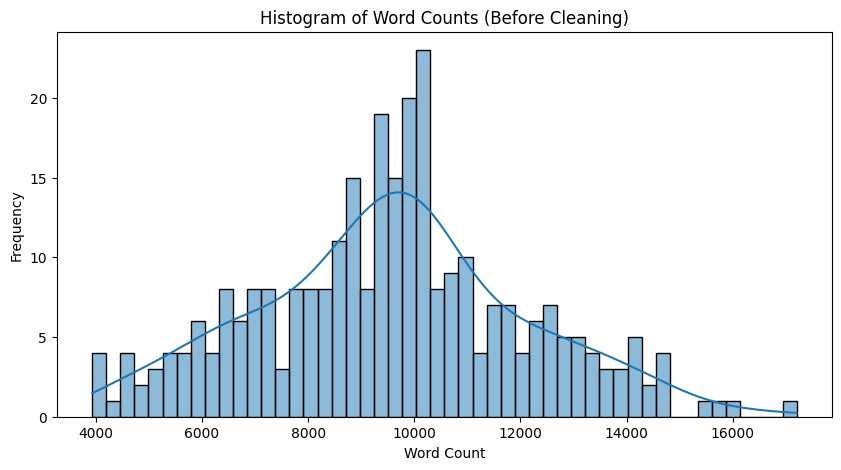

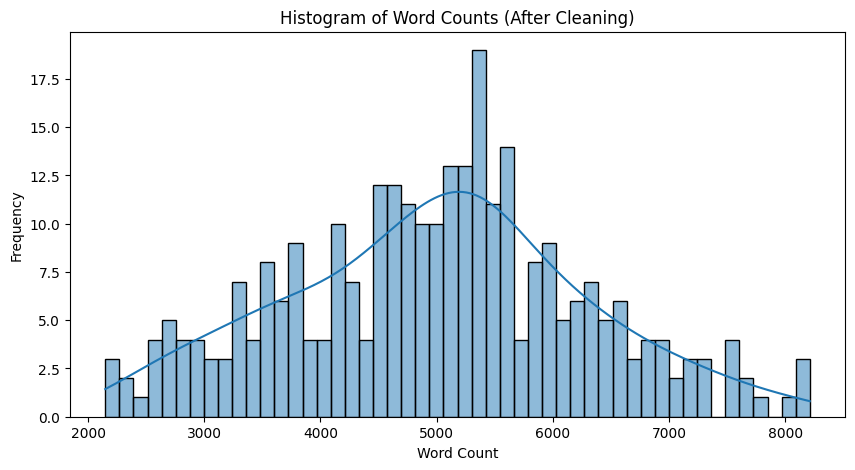

In [12]:
# Histogram of word counts before cleaning
plt.figure(figsize=(10, 5))
sns.histplot(combined_transcripts_df['word_count'], bins=50, kde=True)
plt.title('Histogram of Word Counts (Before Cleaning)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Histogram of word counts after cleaning
plt.figure(figsize=(10, 5))
sns.histplot(combined_transcripts_df['clean_word_count'], bins=50, kde=True)
plt.title('Histogram of Word Counts (After Cleaning)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


Counting Most Common Words

In [13]:
# Combine all cleaned transcripts into one large string
all_words = ' '.join(combined_transcripts_df['clean_content'])

# Tokenize and count word frequencies
# Selecting the most common 50 words
word_freq = Counter(all_words.split())
most_common = word_freq.most_common(50)
print(most_common)


[('’', 16571), ('year', 14719), ('think', 14381), ('quarter', 13736), ('u', 9242), ('going', 8887), ('question', 8639), ('well', 8309), ('aircraft', 7160), ('revenue', 7070), ('cost', 6935), ('like', 6540), ('million', 6488), ('next', 6204), ('would', 6093), ('one', 5917), ('really', 5898), ('get', 5732), ('first', 5731), ('thank', 5692), ('time', 5676), ('back', 5633), ('good', 5580), ('thats', 5532), ('weve', 5490), ('operator', 5141), ('capacity', 5134), ('thanks', 5015), ('customer', 4928), ('look', 4870), ('business', 4819), ('new', 4807), ('see', 4792), ('demand', 4766), ('airline', 4763), ('kind', 4743), ('also', 4720), ('continue', 4497), ('point', 4488), ('right', 4433), ('thing', 4411), ('growth', 4293), ('expect', 4274), ('go', 4243), ('last', 4232), ('lot', 4191), ('know', 4183), ('come', 4170), ('call', 4103), ('2019', 4086)]


So far, the words are fairly common and do not seem very indicative of determining sentiment or gleaning insights. This was expected and I initially processed the text lightly in order to get a better idea of how the data looked closer to it's raw form. Further work and processing will be needed in order to determine better how to process here. 

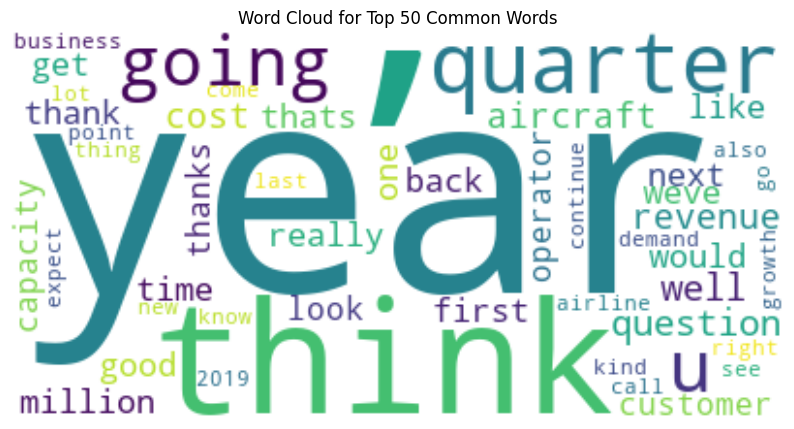

In [14]:
# Create a dictionary with your most common words for the WordCloud
word_freq_dict = {word: count for word, count in most_common}

# Generate a word cloud image from the frequencies
wordcloud = WordCloud(background_color='white', max_words=50).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Cloud for Top 50 Common Words')
plt.show()


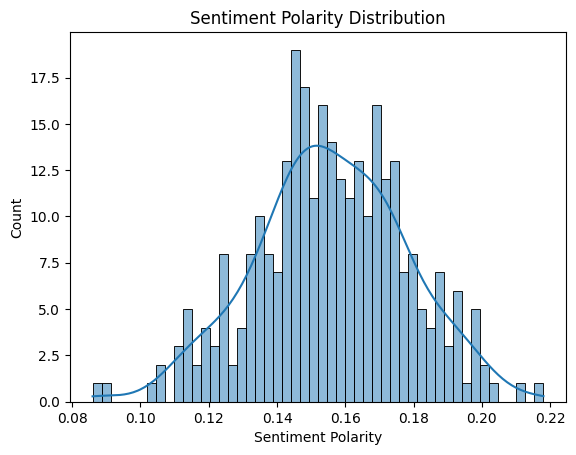

In [15]:
# Calculate sentiment polarity for each cleaned transcript
combined_transcripts_df['sentiment'] = combined_transcripts_df['clean_content'].apply(lambda text: sentiment_polarity(text))

# Plot sentiment distribution
sns.histplot(combined_transcripts_df['sentiment'], bins=50, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()

We have looked at single tokens so far, but now will take a look at bi-grams to understand what groupings of words exist and any further exploration that may be needed here

In [16]:
bigrams = combined_transcripts_df['clean_content'].apply(lambda text: extract_ngrams(text, 2))

# Counting bigrams
bigram_freq = Counter([bigram for sublist in bigrams for bigram in sublist])
print(bigram_freq.most_common(20))

[('little bit', 2310), ('fourth quarter', 2218), ('next question', 2117), ('first quarter', 2042), ('next year', 2003), ('second quarter', 1980), ('third quarter', 1943), ('good morning', 1705), ('question come', 1664), ('operator next', 1464), ('last year', 1408), ('go ahead', 1036), ('going forward', 994), ('cash flow', 990), ('operator thank', 985), ('full year', 975), ('helane becker', 973), ('balance sheet', 926), ('duane pfennigwerth', 870), ('please go', 863)]


As can be expected, word count distributions by quarter vary from company to company and quarter to quarter. Further analysis would be needed to determine how this would affect, if at all, company metrics. 

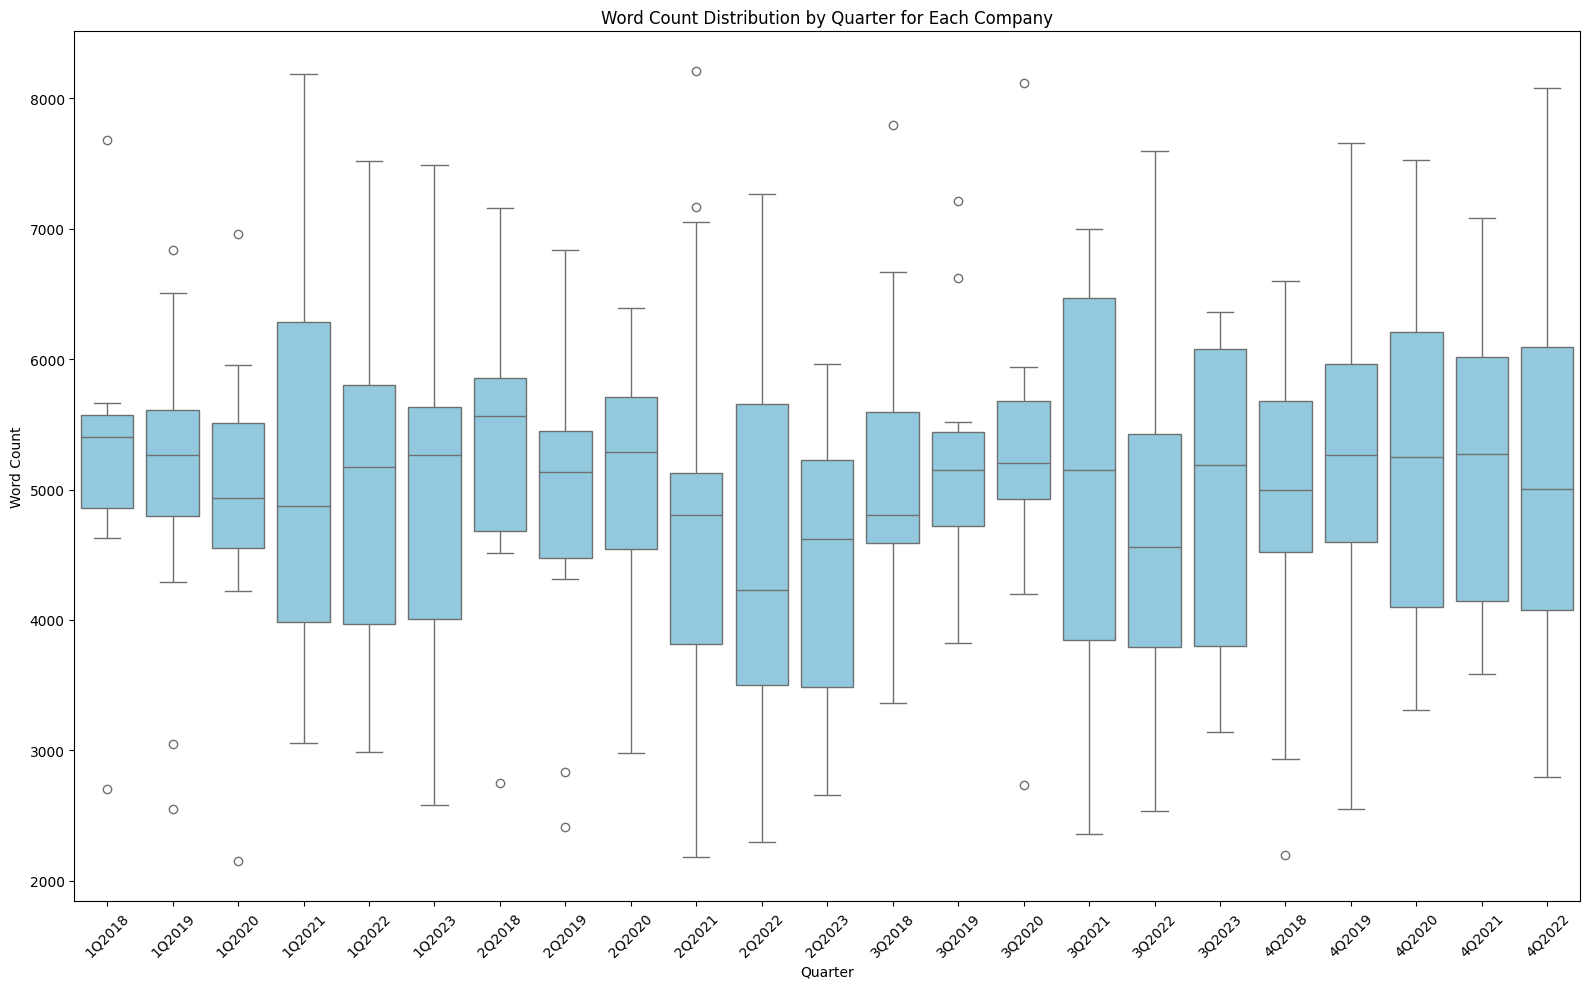

In [17]:
combined_transcripts_df['clean_word_count'] = pd.to_numeric(combined_transcripts_df['clean_word_count'], errors='coerce')
# Create 'quarter_year' and sort
combined_transcripts_df['quarter_year'] = combined_transcripts_df['quarter'].astype(str) + 'Q' + combined_transcripts_df['year'].astype(str)
combined_transcripts_df.sort_values('quarter_year', inplace=True)

# Create the boxplot
plt.figure(figsize=(16, 10))
sns.boxplot(data=combined_transcripts_df, x='quarter_year', y='clean_word_count', color='skyblue')
plt.title('Word Count Distribution by Quarter for Each Company')
plt.xlabel('Quarter')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

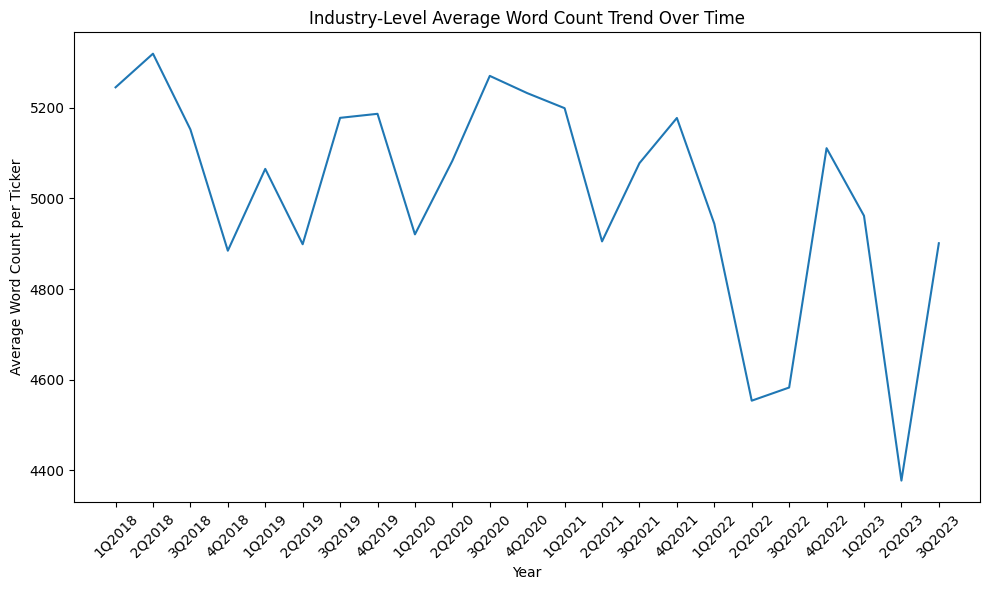

In [18]:
# Calculate the average word count per ticker for each year
average_word_counts_over_time = combined_transcripts_df.groupby(['quarter_year', 'year', 'quarter']).apply(lambda x: x['clean_word_count'].sum() / x['symbol'].nunique()).reset_index(name='average_word_count_per_ticker')
average_word_counts_over_time.sort_values(by=['year','quarter'], inplace = True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_word_counts_over_time, x='quarter_year', y='average_word_count_per_ticker')
plt.title('Industry-Level Average Word Count Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Average Word Count per Ticker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()